In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data and Preprocessing

In [327]:
# Keep only needed columns
feature_names = [
    "Age", "Workclass", "Education", 
    "Occupation", "Relationship", "Race", 
    "Sex", "Capital Gain", "Capital Loss", 
    "Hours per week", "Country", "label"
]

df = pd.DataFrame(
  np.genfromtxt('dataset/adult.csv', delimiter=', ', dtype=str, usecols=(0,1,3,6,7,8,9,10,11,12,13,14)),    
  columns=feature_names
)

# Drop missing values denoted as ?
cols = list(df.columns)
df[cols] = df[cols].replace(['?'], np.nan)
df = df.dropna()


# Declare categorical columns
categorical_columns=[
   "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Country", "label"
]

# Assign type to features
for feature in feature_names:
    if feature in categorical_columns:
        df[feature] = df[feature].astype("category")
    else:
        df[feature] = df[feature].astype("int")

# Make bins for age and hours per week
df['Age'] = pd.cut(df['Age'], bins=[16, 35 , 90],labels=['Young','Aged'])
df["Hours per week"] = pd.cut(
            x=df["Hours per week"],
            bins=[0.9, 25, 39, 40, 55, 100],
            labels=["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"])

# Replace "Husband" and "Wife" values with the unisex "Married"
df["Relationship"] = df["Relationship"].replace('Husband','Married')
df["Relationship"] = df["Relationship"].replace('Wife','Married')

# Will have income >50k (1 or 0)
df["label"] = df["label"].replace('>50K',1)
df["label"] = df["label"].replace('<=50K',0)

df.sample(5)

/tmp/ipykernel_412512/1809994134.py:40: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Relationship"] = df["Relationship"].replace('Husband','Married')
/tmp/ipykernel_412512/1809994134.py:41: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["Relationship"] = df["Relationship"].replace('Wife','Married')
/tmp/ipykernel_412512/1809994134.py:44: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
12488,Young,Private,HS-grad,Transport-moving,Married,White,Male,0,0,BrainDrain,United-States,1
5130,Aged,Private,10th,Craft-repair,Not-in-family,White,Male,0,0,OverTime,United-States,0
8616,Young,Private,Bachelors,Sales,Not-in-family,Black,Male,0,0,PartTime,United-States,0
15453,Aged,State-gov,HS-grad,Adm-clerical,Married,White,Female,0,0,FullTime,United-States,1
13555,Aged,Private,Assoc-acdm,Sales,Married,White,Male,7688,0,OverTime,United-States,1


In [328]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30162 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             30162 non-null  category
 1   Workclass       30162 non-null  category
 2   Education       30162 non-null  category
 3   Occupation      30162 non-null  category
 4   Relationship    30162 non-null  category
 5   Race            30162 non-null  category
 6   Sex             30162 non-null  category
 7   Capital Gain    30162 non-null  int64   
 8   Capital Loss    30162 non-null  int64   
 9   Hours per week  30162 non-null  category
 10  Country         30162 non-null  category
 11  label           30162 non-null  category
dtypes: category(10), int64(2)
memory usage: 1005.5 KB


## Model Creation

In [329]:
# Data preprocessing to train model
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tabular_data = Tabular(
   df,
   categorical_columns=[
  "Age", "Workclass", "Education", "Occupation", "Relationship", "Race", "Sex", "Hours per week", "Country"
],
   target_column='label'
)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)

# Split data into training and (validation + test) datasets
train, X_temp, train_labels, y_temp  = \
    train_test_split(x[:, :-1], x[:, -1], train_size=0.70, random_state = 123)

# Split data validation and test sets
val, test, val_labels, test_labels = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

test_labels = test_labels.astype(int)

print('Training data shape:   {}'.format(train.shape))
print('Validation data shape:  {}'.format(val.shape))
print('Test data shape:        {}'.format(test.shape))

# Train a Random Forest model
model = RandomForestClassifier(random_state=123)
model.fit(train, train_labels)

predict_function=lambda z: model.predict_proba(transformer.transform(z))

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)

display(tabular_data.target_column)
display(train_labels[:2])

Training data shape:   (21113, 99)
Validation data shape:  (4524, 99)
Test data shape:        (4525, 99)


'label'

array([1., 0.])

In [330]:
# Model Predictions
test_df = test_data.to_pd()
test_df["label"] = test_labels
predictions = model.predict(test)
test_df["prediction"] = predictions

test_df.sample(5)

,Age,Workclass,Education,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label,prediction
4387,Aged,Private,Some-college,Sales,Married,White,Male,0.0,0.0,OverTime,United-States,0,1.0
1614,Young,Private,7th-8th,Handlers-cleaners,Married,White,Male,0.0,0.0,FullTime,United-States,0,0.0
1355,Aged,State-gov,Masters,Prof-specialty,Not-in-family,Asian-Pac-Islander,Female,0.0,0.0,FullTime,China,0,0.0
1075,Aged,Private,Bachelors,Exec-managerial,Unmarried,White,Female,0.0,0.0,FullTime,Cuba,0,0.0
732,Young,Federal-gov,Bachelors,Protective-serv,Not-in-family,White,Male,0.0,0.0,OverTime,United-States,1,0.0


Test: accuracy=0.8513
Test: TP=734, TN=3118, FP=263, FN=410


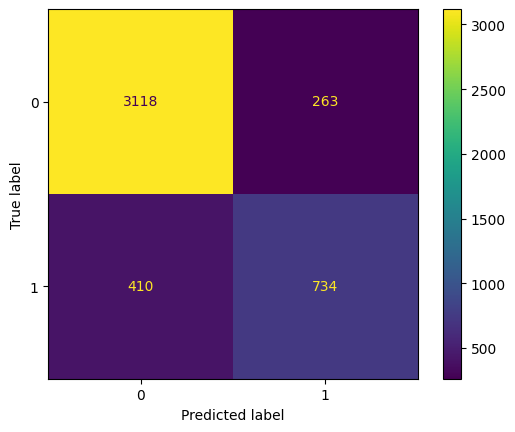

In [331]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(test_labels, predictions)
print(f'Test: {accuracy=:.4f}')

cm = confusion_matrix(test_labels, predictions)

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print(f"Test: {TP=}, {TN=}, {FP=}, {FN=}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, )
disp.plot();